<a href="https://colab.research.google.com/github/HaiYen-hp/Handwritten-number-recognition/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from keras.datasets import mnist
from scipy.special import softmax
import datetime

In [ ]:
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

In [ ]:
# One-hot matrix
from scipy import sparse
def convert_labels(y, num_classes):
    """
      Chuyển nhãn 1D thành ma trận nhãn: mỗi cột của ma trận này tương ứng với 1 phần tử trong y. 
      Trong cột thứ i của Y, chỉ một phần tử khác không nằm ở vị trí thứ y [i] bằng 1
    
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (num_classes, len(y))).toarray()
    return Y

In [ ]:
def softmaxx(z):
    """
      implement hàm softmax
      input: numpy ndarray is W*x + b
      output: numpy ndarray
      
    """
    exp_list = np.exp(z - np.max(z))
    result = 1/sum(exp_list) * exp_list
    return result

**Part 1**

In [ ]:
def multinomial_logreg_loss_i(x, y, gamma, W):
    """
      x là mẫu (num_inputs)
      y là nhãn (num_classes)
      gamma là hằng số chuẩn L2
      param là tham số W
      return cross-entropy loss
    """
    y_pred = softmax(np.matmul(W,x))
    l2_reg = (gamma/2) * np.linalg.norm(W)**2
    loss = -np.matmul(y.T, np.log(y_pred)) + l2_reg
    return loss.item()

In [ ]:
def multinomial_logreg_grad_i(x, y, gamma, W):
    """
      Tính toán gradient của một mẫu duy nhất về mục tiêu hồi quy logistic đa thức, với regularization
      x là mẫu của tập huấn luyện (num_inputs)
      y là nhãn của tập huấn luyện (num_classes)
      gamma hằng số chuẩn L2 
      param là tham số W
      return gradient của các thông số mô hình

    """
    y_hat = softmax(np.matmul(W,x)) - y    
    result =  np.dot(y_hat.reshape(-1,1), x.reshape(1,-1)) + gamma*W # shape của x là (785,1) 
    return result

In [ ]:
# test là hàm multinomial_logreg_grad_i là đạo hàm của multinomial_logreg_loss_i
def test_gradient(X,Y,gamma,W,alpha):
  num = X.shape[1]
  count = 0
  for i in range(num):
    Xi, Yi = X[:,i], Y[:,i]
    V = np.random.rand(W.shape[0], W.shape[1]) # V có dạng (10,785) giống với tham số W
    function1 = multinomial_logreg_loss_i(Xi, Yi, gamma, W + alpha*V)
    function2 = multinomial_logreg_loss_i(Xi, Yi, gamma, W)
    FD = (function1-function2)/alpha # đạo hàm bằng công thức định nghĩa sai phân thuận
    V = V.reshape(-1,1)
    grad = multinomial_logreg_grad_i(Xi, Yi, gamma, W)
    grad = grad.reshape(-1,1)
    Gradient = np.dot(V.T, grad).item()
    # khác biệt
    count += abs(Gradient - FD)
    return count / num

**Part 2**

In [ ]:
# Tính đạo hàm của hàm mục tiêu hồi quy logistic đa thức với regularization
def multinomial_logreg_total_grad(X, Y, gamma, W, starter = False):
    """
      X là mẫu huấn luyện (num_inputs x len(train_images))
      Y là nhãn huấn luyện (num_classes x len(train_labels))
      gamma là hằng số chuẩn L2
      param là tham số W
      return gradient của các thông số mô hình
    """
    (num_inputs, n)= X.shape
    ret = 0
    if starter == True:
      ret = W * 0.0
      for i in range(n):
        ret += multinomial_logreg_grad_i(X[:,i], Y[:,i], gamma, W)
    else:
      y_pred = softmax(np.dot(W,X), axis = 0)
      delta_L = np.dot(y_pred - Y, X.T)
      ret = delta_L + gamma * W
    return ret / n

In [ ]:
# Tính cross-entropy loss 
def  multinomial_logreg_total_loss (X, Y, gamma, W, starter = False):
  """
    X là mẫu huấn luyện (num_inputs x len(train_images))
    Y là nhãn huấn luyện (num_classes x len(train_labels))
    gamma là hằng số chuẩn L2
    param là tham số W
    return cross-entropy loss
  """
  (num_inputs, n)= X.shape
  ret = 0
  if starter == True:
    for i in range(n):
      ret += multinomial_logreg_loss_i(X[:,i], Y[:,i], gamma, W)
  else:
    y_pred = softmax(np.dot(W,X), axis = 0)
    log_y_pred = -np.log(y_pred)
    y_mul_y_pred = np.multiply(log_y_pred, Y)
    L = np.sum(y_mul_y_pred)
    ret = L + (gamma/2)*(np.linalg.norm(W))**2
  return ret / n

In [ ]:
# chạy gradient descent trên trên hàm mục tiêu hồi quy logistic đa thức, với regularization
def  gradient_descent(X, Y, gamma, W0, alpha, num_iters, monitor_freq, starter=False):
  """
    X là mẫu huấn luyện (num_inputs x len(train_images))
    Y là nhãn huấn luyện (num_classes x len(train_labels))
    param là tham số W
    gamma là hằng số chuẩn L2
    W0 là giá trị ban đầu của các tham số W
    alpha là step size/learning rate
    num_iters là số lần lặp lại để chạy
    monitor_freq là tần suất xuất ra vector tham số
    return danh sách các thông số mô hình, một tham số mỗi lần "monitor_freq" lặp lại
           nên trả về các tham số mô hình trước lần lặp 0 lần lặp monitor_freq, lần lặp 2 * monitor_freq và một lần nữa ở cuối
           cho tổng số (num_iters / monitor_freq) +1 mô hình, nếu num_iters chia hết cho monitor_freq.
  """
  params = []
  for i in range(num_iters):
    if (i % monitor_freq == 0):
      params.append(W0)
    W0 = W0 - alpha*multinomial_logreg_total_grad(X, Y, gamma, W0, starter)
    #has_converged = np.linalg.norm(multinomial_logreg_total_grad(X, Y, gamma, param, starter))/ len(param) 
  params.append(W0)
  return params

**Part 3**

In [ ]:
'''def Multinomial_logreg_total_loss(X, y, gamma, param):
    """ 
    input: X là output từ data (num_inputs x num_classes)
           y là nhãn (num_inputs x 1)
           param là tham số W
    output: float number
    """
    m = y.shape[0] # 60000 trong tập train, 10000 trong tập test
    softmax_input = softmax(np.matmul(param,x))
    # sử dụng index cho mảng đa chiều để trích xuất
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays
    # softmax xác suất của nhãn chính xác cho mỗi mẫu.
    l2_reg = (gamma/2) * np.linalg.norm(param)**2
    log_likelihood = -np.dot(y[range(m),y].T, np.log(softmax_input[range(m),y])) + l2_reg
    loss_function = np.sum(log_likelihood)/m
    return loss_function'''

In [ ]:
'''def Multinomial_logreg_total_grad(X, y, gamma, param):
    """ 
    input: X là output từ data (num_inputs x num_classes)
           y là nhãn (num_inputs x 1)
           param là tham số W
    output: float number
    """
    m = y.shape[0]
    y_hat = softmax(np.matmul(param, x))
    grad = np.matmul(y_hat[range(m),y].reshape(-1,1), X.T) + gamma*param
    grad = y_hat/m
    return grad'''

**Part 4**

In [ ]:
# Tính error
def multinomial_logreg_error(X, Y, W):
  """
    X là mẫu huấn luyện (num_inputs x len(data_images))
    Y là nhãn huấn luyện (num_classes x len(data_labels))
    param là tham số W
    return lỗi mô hình như một tỷ lệ phần trăm của các nhãn không chính xác.
  """
  Y = Y.T
  y_pred = softmax(np.matmul(W, X), axis = 0).T # tính softmax theo cột rồi chuyển vị ma trận y_pred thành (num_inputs x num_classes)
  count = 0
  for i in range(len(Y)):
    pred = np.argmax(y_pred[i])
    if(Y[i,pred] != 1):
      count += 1
  return count/len(Y)

In [ ]:
def pred(W, X):
    """
      X là là mẫu (num_inputs x len(data_images))
      dự đoán đầu ra của X được xác định theo vị trí của xác suất tối đa
    """
    A = softmax(np.dot(param,X))
    return np.argmax(A, axis = 0)

In [ ]:
#ước tính lỗi
def estimate_multinomial_logreg_error(X, Y, W, nsamples):
    """
      X là mẫu huấn luyện (num_inputs x len(train_images))
      Y là nhãn huấn luyện (num_classes x len(train_labels))
      param là tham số W
      gamma là hằng số chuẩn L2
      nsamples số lượng mẫu cần sử dụng để ước tính
      return lỗi mô hình ước tính khi lấy mẫu thay thế
    """
    X_sub, Y_sub = X.T, Y.T
    n = X.shape[1]
    perm = [np.random.randint(0,n) for _ in range(nsamples)]
    X_sub = X.T[perm]
    Y_sub = Y.T[perm]
    estimated_error = multinomial_logreg_error(X_sub.T, Y_sub.T, W)
    return estimated_error

In [ ]:
Xtrain_images_display = np.asarray(Xtrain)
Xtrain_images_display = Xtrain_images_display.reshape(len(Xtrain_images_display) , 28, 28)
Xtrain_images = Xtrain.transpose() / 255.0
ytrain_labels_display = np.array(ytrain.tolist())
Xtest_images_display = np.asarray(Xtest)
Xtest_images_display = Xtest_images_display.reshape(len(Xtest_images_display) , 28, 28)
Xtest_images = Xtest.transpose() / 255.0
ytest_labels_display = np.array(ytest.tolist())

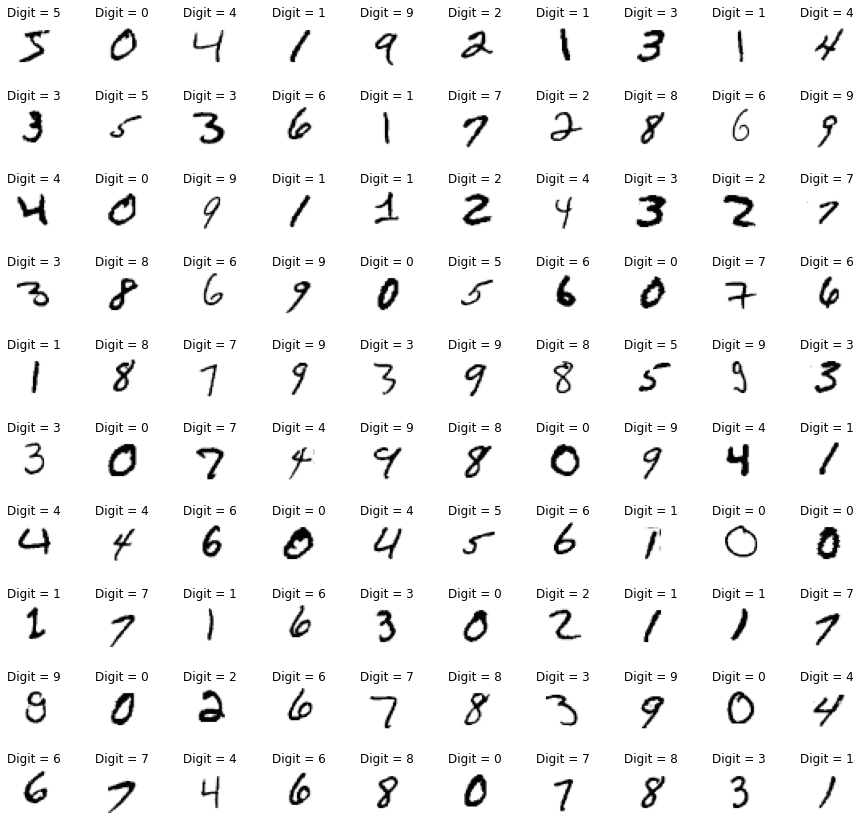

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 100):
    axes[i].imshow(Xtrain_images_display[i], cmap="Greys")
    axes[i].set_title("Digit = %s" % ytrain_labels_display[i])
    axes[i].axis("off")
    plt.subplots_adjust(wspace=1)

In [ ]:
if __name__ == "__main__":
  print("Hình dạng ban đầu Xtrain:", Xtrain_images.shape)
  print("Hình dạng ban đầu Ytrain:", ytrain.shape)
  print("Hình dạng ban đầu Xtest:", Xtest_images.shape)
  print("Hình dạng ban đầu Ytest:", ytest.shape)
  Xtrain_images = Xtrain_images.reshape(784, 60000)
  print("Hình dạng sau khi đổi shape Xtrain:", Xtrain_images.shape)
  Xtest_images = Xtest_images.reshape(784, 10000)
  print("Hình dạng sau khi đổi shape Xtest:", Xtest_images.shape)
  addrow_train = np.ones_like(np.array(Xtrain_images[1]))
  addrow_test = np.ones_like(np.array(Xtest_images[1]))
  # thêm 1 row có giá trị là 1 vào matrix 
  Xtrain_images = np.append(Xtrain_images, [addrow_train], axis = 0) 
  Xtest_images = np.append(Xtest_images, [addrow_test], axis =0)
  print(f"Hình dạng của tập train sau khi thêm hàng {Xtrain_images.shape}, hình dạng của tập test sau khi thêm hàng {Xtest_images.shape}")
  # convert to one-hot matrix
  ytrain_onehot = convert_labels(ytrain, len(set(ytrain)))
  ytest_onehot = convert_labels(ytest, len(set(ytest)))
   # khai bao tham so
  param = np.zeros([ytrain_onehot.shape[0],Xtrain_images.shape[0]])
  # convert to matrix
  Xtrain_images, Xtest_images, ytrain_onehot, ytest_onehot = np.matrix(Xtrain_images), np.matrix(Xtest_images), np.matrix(ytrain_onehot), np.matrix(ytest_onehot)

Hình dạng ban đầu Xtrain: (28, 28, 60000)
Hình dạng ban đầu Ytrain: (60000,)
Hình dạng ban đầu Xtest: (28, 28, 10000)
Hình dạng ban đầu Ytest: (10000,)
Hình dạng sau khi đổi shape Xtrain: (784, 60000)
Hình dạng sau khi đổi shape Xtest: (784, 10000)
Hình dạng của tập train sau khi thêm hàng (785, 60000), hình dạng của tập test sau khi thêm hàng (785, 10000)



Chạy part 1 ...

Với alpha = 0.1, chênh lệch trung bình là: 4.894456680827856e-06
Với alpha = 0.01, chênh lệch trung bình là: 7.386082920700421e-07
Với alpha = 0.001, chênh lệch trung bình là: 5.076127519759536e-08
Với alpha = 0.0001, chênh lệch trung bình là: 6.7692103127958704e-09
Với alpha = 1e-05, chênh lệch trung bình là: 4.04493148620233e-10
Với alpha = 1e-06, chênh lệch trung bình là: 3.367956024254622e-11
Với alpha = 1e-07, chênh lệch trung bình là: 5.0721055947870276e-12
Với alpha = 1e-08, chênh lệch trung bình là: 2.145948159911389e-13
Với alpha = 1e-09, chênh lệch trung bình là: 4.7898780127416295e-12
Với alpha = 1e-10, chênh lệch trung bình là: 2.2351893669281254e-13

Kết thúc Part 1.



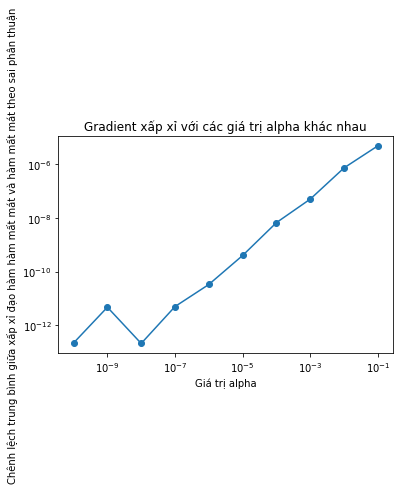

In [ ]:
#PART1
print(f"\nChạy part 1 ...\n")
gamma = 0.0001
list_diff = []
W = np.zeros([ytrain_onehot.shape[0],Xtrain_images.shape[0]])
alpha = [10**i for i in range(-1,-11,-1)]
for a in alpha:
  ret =  test_gradient(Xtrain_images, ytrain_onehot, gamma, W, a)
  print(f"Với alpha = {a}, chênh lệch trung bình là: {ret}")
  list_diff.append(ret)
plt.loglog(alpha, list_diff)
plt.scatter(alpha, list_diff, marker='o')
plt.title("Gradient xấp xỉ với các giá trị alpha khác nhau")
plt.xlabel("Giá trị alpha")
plt.ylabel("Chênh lệch trung bình giữa xấp xỉ đạo hàm hàm mất mát và hàm mất mát theo sai phân thuận")
plt.savefig("alpha_avg_dist_plot.png")
print("\nKết thúc Part 1.\n")

In [ ]:
#PART2
print(f"\nChạy part 2 ... \n")
gamma = 0.0001
alpha = 1.0
num_Iter = 10
monitorFreq = 10
W = np.zeros([ytrain_onehot.shape[0],Xtrain_images.shape[0]])
print(f"Chạy chương với các tham số, chạy với vòng for: alpha(learning rate) = {alpha}, gamma = {gamma}, số vòng lặp = {num_Iter}, tần suất ra vector tham số = {monitorFreq}")
start = datetime.datetime.now()
W_for = gradient_descent(Xtrain_images, ytrain_onehot, gamma, W, alpha, num_Iter, monitorFreq, True)
end = datetime.datetime.now()
print(f"Start: {start}\nEnd: {end}")
print(f"Thời gian thực hiện cho cấu hình với các tham số trên là: {end - start}")
print("\nKết thúc Part 2.\n")


Chạy part 2 ... 

Chạy chương với các tham số, chạy với vòng for: alpha(learning rate) = 1.0, gamma = 0.0001, số vòng lặp = 10, tần suất ra vector tham số = 10
Start: 2021-08-13 13:17:06.259370
End: 2021-08-13 13:18:17.619202
Thời gian thực hiện cho cấu hình với các tham số trên là: 0:01:11.359832

Kết thúc Part 2.



In [ ]:
#PART3
print(f"\nChạy part 3 ... \n")
end = datetime.datetime.now()
print(f"Chạy chương với các tham số và numpy matrix: alpha(learning rate) = {alpha}, gamma = {gamma}, số vòng lặp = {num_Iter}, tần suất ra vector tham số = {monitorFreq}")
start = datetime.datetime.now()
W_numpy = gradient_descent(Xtrain_images, ytrain_onehot, gamma, W, alpha, num_Iter, monitorFreq)
end = datetime.datetime.now()
print(f"Start: {start} \nEnd: {end}")
print(f"Thời gian thực hiện cho cấu hình với các tham số trên là: {end - start}")
print("\nKết thúc Part 3.\n")


Chạy part 3 ... 

Chạy chương với các tham số và numpy matrix: alpha(learning rate) = 1.0, gamma = 0.0001, số vòng lặp = 10, tần suất ra vector tham số = 10
Start: 2021-08-13 13:18:17.640539 
End: 2021-08-13 13:18:21.275231
Thời gian thực hiện cho cấu hình với các tham số trên là: 0:00:03.634692

Kết thúc Part 3.



Part 3 nhanh hơn part 2

In [ ]:
#Part4
num_Iter = 1000
print(f"Chạy chương với các tham số và numpy matrix: alpha(learning rate) = {alpha}, gamma = {gamma}, số vòng lặp = {num_Iter}, tần suất ra vector tham số = {monitorFreq}")
start = datetime.datetime.now()
W_numpy = gradient_descent(Xtrain_images, ytrain_onehot, gamma, W, alpha, num_Iter, monitorFreq)
end = datetime.datetime.now()
print(f"Thời gian thực hiện cho cấu hình với các tham số trên là: {end - start}")

est_error_train_100, est_error_train_1000, error, loss, est_error_test_1000, est_error_test_100, loss_np_test, error_np_test = [], [], [], [], [], [], [], []
start = datetime.datetime.now()
exact_error = multinomial_logreg_error(Xtrain_images, ytrain_onehot, W_numpy[-1])
end = datetime.datetime.now()
print("\nThời gian chạy để nhận được lỗi tập huấn luyện với toàn bộ tập dữ liệu trên một mô hình là:", end - start)

start = datetime.datetime.now()
est_err_100 = estimate_multinomial_logreg_error(Xtrain_images, ytrain_onehot, W_numpy[-1], 100)
end = datetime.datetime.now()
print("\nThời gian chạy để nhận được lỗi tập huấn luyện với việc lấy mẫu con 100 mẫu trên một mô hình là:", end - start)

start = datetime.datetime.now()
est_err_1000 = estimate_multinomial_logreg_error(Xtrain_images, ytrain_onehot, W_numpy[-1], 1000)
end = datetime.datetime.now()
print("\nThời gian chạy để nhận được lỗi tập huấn luyện với việc lấy mẫu con 1000 mẫu trên một mô hình là:", end - start)
for w in W_numpy:
  loss.append(multinomial_logreg_total_loss(Xtrain_images, ytrain_onehot, gamma, w))
  loss_np_test += [multinomial_logreg_total_loss(Xtest_images, ytest_onehot, gamma,  w)]
  error.append(multinomial_logreg_error(Xtrain_images, ytrain_onehot,  w))
  error_np_test += [multinomial_logreg_error(Xtest_images, ytest_onehot,  w)]
  num_example = 100
  est_error_train_100.append(estimate_multinomial_logreg_error(Xtrain_images, ytrain_onehot,  w, num_example))
  est_error_test_100.append(estimate_multinomial_logreg_error(Xtest_images, ytest_onehot,  w, num_example))  
  num_example_ = 1000
  est_error_train_1000.append(estimate_multinomial_logreg_error(Xtrain_images, ytrain_onehot,  w, num_example_))
  est_error_test_1000.append(estimate_multinomial_logreg_error(Xtest_images, ytest_onehot,  w, num_example_))

Chạy chương với các tham số và numpy matrix: alpha(learning rate) = 1.0, gamma = 0.0001, số vòng lặp = 1000, tần suất ra vector tham số = 10
Thời gian thực hiện cho cấu hình với các tham số trên là: 0:05:57.273355

Thời gian chạy để nhận được lỗi tập huấn luyện với toàn bộ tập dữ liệu trên một mô hình là: 0:00:01.102108

Thời gian chạy để nhận được lỗi tập huấn luyện với việc lấy mẫu con 100 mẫu trên một mô hình là: 0:00:00.005181

Thời gian chạy để nhận được lỗi tập huấn luyện với việc lấy mẫu con 1000 mẫu trên một mô hình là: 0:00:00.045307


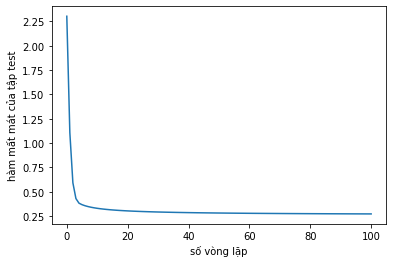

In [ ]:
plt.plot(range(num_Iter//monitorFreq+1), loss_np_test) # cột Ox là vòng lặp, cột Oy là error trên file test
plt.xlabel('số vòng lặp') 
plt.ylabel('hàm mất mát của tập test') 
plt.show()

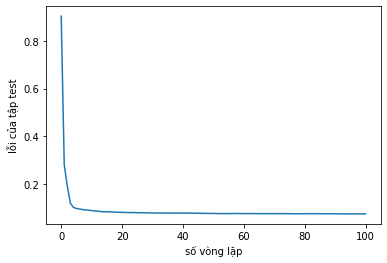

In [ ]:
plt.plot(range(num_Iter//monitorFreq+1), error_np_test) # cột Ox là vòng lặp, cột Oy là error trên file test
plt.xlabel('số vòng lặp') 
plt.ylabel('lỗi của tập test') 
plt.show()

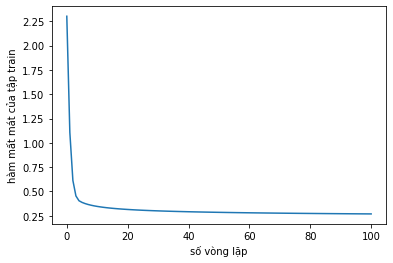

In [ ]:
plt.plot(range(num_Iter//monitorFreq+1), loss) # cột Ox là vòng lặp, cột Oy là loss trên file train
plt.xlabel('số vòng lặp') 
plt.ylabel('hàm mất mát của tập train') 
plt.show()

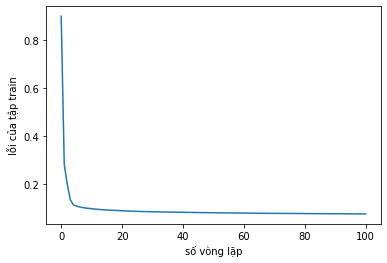

In [ ]:
plt.plot(range(num_Iter//monitorFreq+1), error) # cột Ox là vòng lặp, cột Oy là error trên file train
plt.xlabel('số vòng lặp') 
plt.ylabel('lỗi của tập train') 
plt.show()

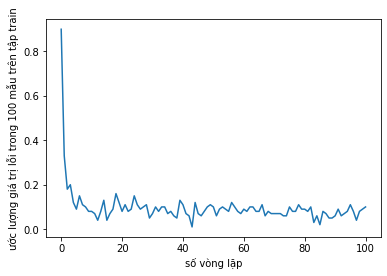

In [ ]:

plt.plot(range(num_Iter//monitorFreq+1), est_error_train_100) # cột Ox là vòng lặp, cột Oy là ước lượng giá trị lỗi trong 100 mẫu trên file train
plt.xlabel('số vòng lặp') 
plt.ylabel('ước lượng giá trị lỗi trong 100 mẫu trên tập train') 
plt.show()

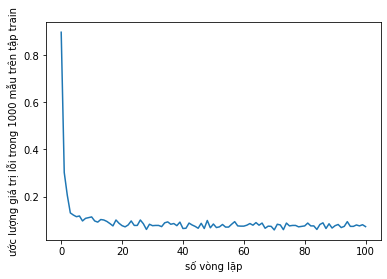

In [ ]:

plt.plot(range(num_Iter//monitorFreq+1), est_error_train_1000) # cột Ox là vòng lặp, cột Oy là ước lượng giá trị lỗi trong 1000 mẫu trên file train
plt.xlabel('số vòng lặp') 
plt.ylabel('ước lượng giá trị lỗi trong 1000 mẫu trên tập train') 
plt.show()

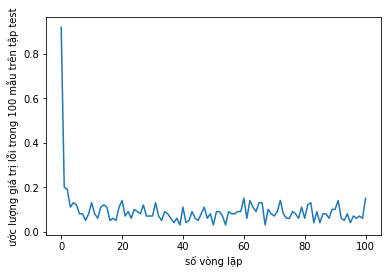

In [ ]:
plt.plot(range(num_Iter//monitorFreq+1), est_error_test_100) # cột Ox là vòng lặp, cột Oy là ước lượng giá trị lỗi trong 100 mẫu trên file test
plt.xlabel('số vòng lặp') 
plt.ylabel('ước lượng giá trị lỗi trong 100 mẫu trên tập test') 
plt.show()

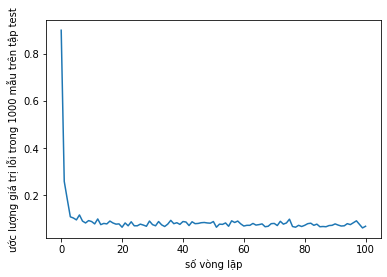

In [ ]:
plt.plot(range(num_Iter//monitorFreq+1), est_error_test_1000) # cột Ox là vòng lặp, cột Oy là ước lượng giá trị lỗi trong 1000 mẫu trên file test
plt.xlabel('số vòng lặp') 
plt.ylabel('ước lượng giá trị lỗi trong 1000 mẫu trên tập test') 
plt.show()

In [ ]:
print("\nKết thúc Part 4.\n")


Kết thúc Part 4.

